In [2]:
import wandb
api = wandb.Api(timeout=3600)
# run_name = "gpts-multiply-1-ic-deep-4"
# run = api.runs(f"reasoning/think-hard", {"or": [{"config.experiment_name": run_name}]})
runs = api.runs("reasoning/think-hard", per_page=100)

In [3]:
import os
import pandas as pd
import json
import datetime
import re

# Create directory if it doesn't exist
if not os.path.exists('expruns'):
    os.makedirs('expruns')

timestamp = datetime.datetime(2023, 9, 25, 18, 0).timestamp()


for r in runs:
    if r.state == "finished" and r.summary['_timestamp'] > timestamp:
        print(r.name)

        # Download Prediction Table
        table = r.summary["Prediction Table"]
        # print(table)
        artifact = r.logged_artifacts()[2]
        table_dir = artifact.download()
        # print(table_dir)
        table_name = "Prediction Table"
        table_path = f"{table_dir}/{table_name}.table.json"
        match = re.search('gpts-digit-multiply-fixed-dataset-(\d+)-ic-deep-(\d+)$', r.name)

        # If unable to extract information, skip this record
        if match is None:
            print(f"Skipping {r.name} due to unmatched pattern.")
            continue

        tokens, depth = match.groups()
        if int(tokens) > 30:
            print("Skip more than 30")
            continue
        
        try:

            with open(table_path) as file:
                json_dict = json.load(file)
            prediction_table = pd.DataFrame(json_dict["data"], columns=json_dict["columns"])

            # Check if file already exists and append a number if it does
            # Select only the columns "Predictions" and "True Labels"
            # inputs have a pattern of {n1}*{n2}[compute]....[compute]---{output}
            # parse out the n1 and n2 in separate columns. You can split at "*" and also replace "[compute]" with "". The right side can be ignored
            prediction_table[['n1', 'temp_n2']] = prediction_table['Input'].str.split('*', expand=True)

            # Step 2: Remove '[compute]...' from 'temp_n2'
            prediction_table['n2'] = prediction_table['temp_n2'].str.replace(r'\[compute\]', '', regex=True)
            prediction_table['n2'] = prediction_table['n2'].str.extract('(\d+)')

            # Select only the columns "n1", "n2", "Predictions", and "True Labels"
            prediction_table = prediction_table[['n1', 'n2', 'Predictions', 'True Labels']]
            prediction_table['tokens'] = tokens
            prediction_table['depth'] = depth

            
            i = 1
            file_name = f'{r.name}_{i}'
            while os.path.isfile(f'expruns/{file_name}-all.csv'):
                file_name = f'{r.name}_{i}'
                i += 1

            prediction_table['run_number'] = i
            # Save the dataframe to a csv file
            prediction_table.to_csv(f'expruns/{file_name}-all.csv', index=False)
        except:
            print("Error", r.name)


gpts-digit-multiply-fixed-dataset-10-ic-deep-6


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-10-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-10-ic-deep-2


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-10-ic-deep-3


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-5-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-6


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-5-ic-deep-6


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-2


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-5-ic-deep-3


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-3


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-5-ic-deep-2


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-6


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-5-ic-deep-3


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-10-ic-deep-2


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-10-ic-deep-3


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-2


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-10-ic-deep-2


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-5-ic-deep-3


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-10-ic-deep-6


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-5-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-5-ic-deep-2


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-2


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-5-ic-deep-6


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-3


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-6


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-10-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-5-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-1-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-20-ic-deep-2


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-30-ic-deep-6


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-30-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-20-ic-deep-3


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-30-ic-deep-3


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-20-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-20-ic-deep-2


wandb:   4 of 4 files downloaded.  


Error gpts-digit-multiply-fixed-dataset-20-ic-deep-2
gpts-digit-multiply-fixed-dataset-20-ic-deep-6


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-30-ic-deep-2


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-20-ic-deep-6


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-30-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-30-ic-deep-6


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-30-ic-deep-3


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-30-ic-deep-2


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-20-ic-deep-3


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-fixed-dataset-20-ic-deep-4


wandb:   1 of 1 files downloaded.  


gpts-digit-multiply-30-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-2


wandb:   16 of 16 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-50-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-50-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-40-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-40-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-50-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-50-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-40-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-40-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-1-ic-deep-4


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-1-ic-deep-4 due to unmatched pattern.
gpts-digit-multiply-5-ic-deep-4


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-5-ic-deep-4 due to unmatched pattern.
gpts-digit-multiply-1-ic-deep-6


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-1-ic-deep-6 due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-3


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-3 due to unmatched pattern.
gpts-digit-multiply-10-ic-deep-4


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-10-ic-deep-4 due to unmatched pattern.
gpts-digit-multiply-1-ic-deep-4


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-1-ic-deep-4 due to unmatched pattern.
gpts-digit-multiply-5-ic-deep-3


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-5-ic-deep-3 due to unmatched pattern.
gpts-digit-multiply-10-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-10-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-10-ic-deep-3


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-10-ic-deep-3 due to unmatched pattern.
gpts-digit-multiply-5-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-5-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-1-ic-deep-3


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-1-ic-deep-3 due to unmatched pattern.
gpts-digit-multiply-1-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-1-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-4


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-4 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-3


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-3 due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-1


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-1 due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-3


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-3 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-4


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-4 due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-6


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-6 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-6


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-6 due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-1


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-1 due to unmatched pattern.
gpts-digit-multiply-10-ic-deep-6


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-10-ic-deep-6 due to unmatched pattern.
gpts-digit-multiply-5-ic-deep-6


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-5-ic-deep-6 due to unmatched pattern.
gpts-digit-multiply-5-ic-deep-4


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-5-ic-deep-4 due to unmatched pattern.
gpts-digit-multiply-1-ic-deep-6


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-1-ic-deep-6 due to unmatched pattern.
gpts-digit-multiply-10-ic-deep-3


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-10-ic-deep-3 due to unmatched pattern.
gpts-digit-multiply-10-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-10-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-5-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-5-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-5-ic-deep-3


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-5-ic-deep-3 due to unmatched pattern.
gpts-digit-multiply-1-ic-deep-3


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-1-ic-deep-3 due to unmatched pattern.
gpts-digit-multiply-1-ic-deep-2


wandb:   7 of 7 files downloaded.  


Skipping gpts-digit-multiply-1-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-1


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-1 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-3


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-3 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-6


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-6 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-4


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-4 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-1


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-1 due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-2


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-2 due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-4


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-4 due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-6


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-6 due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-6-constant-paramm


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-6-constant-paramm due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-4-constant-paramm


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-4-constant-paramm due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-1-constant-paramm


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-1-constant-paramm due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-6-constant-paramm


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-6-constant-paramm due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-3-constant-paramm


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-3-constant-paramm due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-3-constant-paramm


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-3-constant-paramm due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-2-constant-paramm


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-2-constant-paramm due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-2-constant-paramm


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-2-constant-paramm due to unmatched pattern.
gpts-digit-multiply-20-ic-deep-4-constant-paramm


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-20-ic-deep-4-constant-paramm due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-1-constant-paramm


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-1-constant-paramm due to unmatched pattern.
gpts-digit-multiply-30-ic-deep-3-constant-paramm


wandb:   1 of 1 files downloaded.  


Skipping gpts-digit-multiply-30-ic-deep-3-constant-paramm due to unmatched pattern.


In [6]:
import glob
import pandas as pd

# Get a list of all csv files in the directory
csv_files = glob.glob('expruns/*-all.csv')

# Initialize an empty dataframe
merged_df = pd.DataFrame(columns=["Predictions", "True Labels", "tokens", "depth", "run_number"])

# Loop through the csv files and append them to the dataframe
for file in csv_files:
    df = pd.read_csv(file)
    df["Run name"] = file.split('/')[-1].split('.')[0]  # Extract the run name from the file name
    merged_df = merged_df.append(df, ignore_index=True)

# Save the merged dataframe to a new csv file
merged_df.to_csv('expruns/merged-all.csv', index=False)


/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/3164260776.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df = merged_df.append(df, ignore_index=True)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/3164260776.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df = merged_df.append(df, ignore_index=True)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/3164260776.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df = merged_df.append(df, ignore_index=True)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/3164260776.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [282]:
s = "134"
s1 = "1345"

print(list(zip(s, s1)))

[('1', '1'), ('3', '3'), ('4', '4')]


In [285]:
print(list(range(5, -1, -1)))

[5, 4, 3, 2, 1, 0]


   Predictions  True Labels  tokens  depth  run_number     n1     n2  \
0       183952       182952      30      6           1  242.0  756.0   
1       627264       627264      30      6           1  968.0  648.0   
2        60600        60600      30      6           1  150.0  404.0   
3       466284       466284      30      6           1  732.0  637.0   
4       307366       307366      30      6           1  313.0  982.0   

                                            Run name  
0  gpts-digit-multiply-fixed-dataset-30-ic-deep-6...  
1  gpts-digit-multiply-fixed-dataset-30-ic-deep-6...  
2  gpts-digit-multiply-fixed-dataset-30-ic-deep-6...  
3  gpts-digit-multiply-fixed-dataset-30-ic-deep-6...  
4  gpts-digit-multiply-fixed-dataset-30-ic-deep-6...  


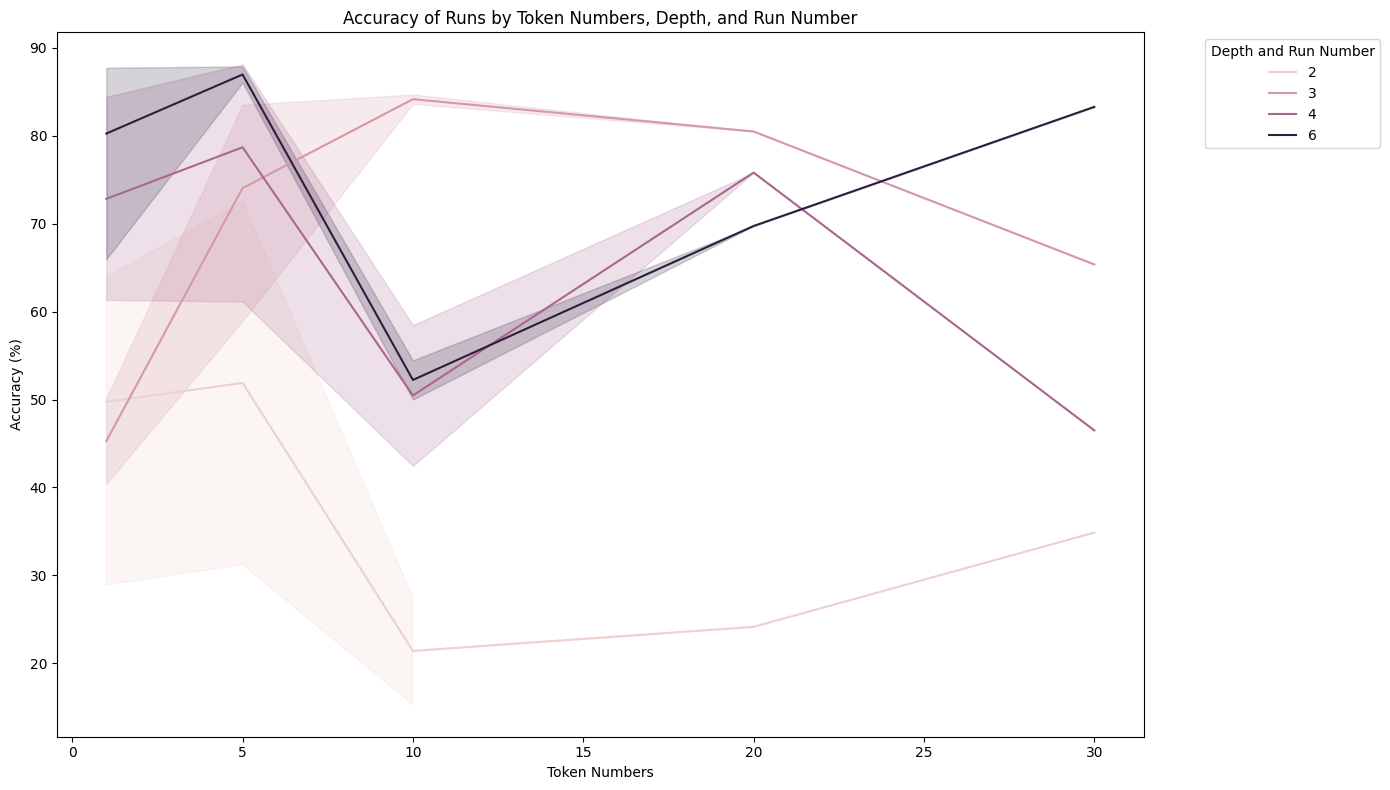

In [24]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = 'expruns/merged-all.csv'
df = pd.read_csv(file_path)
print(df.head())
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the accuracy for each combination of tokens, depth, and run_number
df['Correct'] = (df['Predictions'] == df['True Labels']).astype(int)
accuracy_df = df.groupby(['tokens', 'depth', 'run_number']).agg({'Correct': 'mean'}).reset_index()
accuracy_df['Accuracy'] = accuracy_df['Correct'] * 100  # Convert to percentage

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=accuracy_df, x='tokens', y='Accuracy', hue='depth'), #style='run_number')
plt.title('Accuracy of Runs by Token Numbers, Depth, and Run Number')
plt.xlabel('Token Numbers')
plt.ylabel('Accuracy (%)')
plt.legend(title='Depth and Run Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

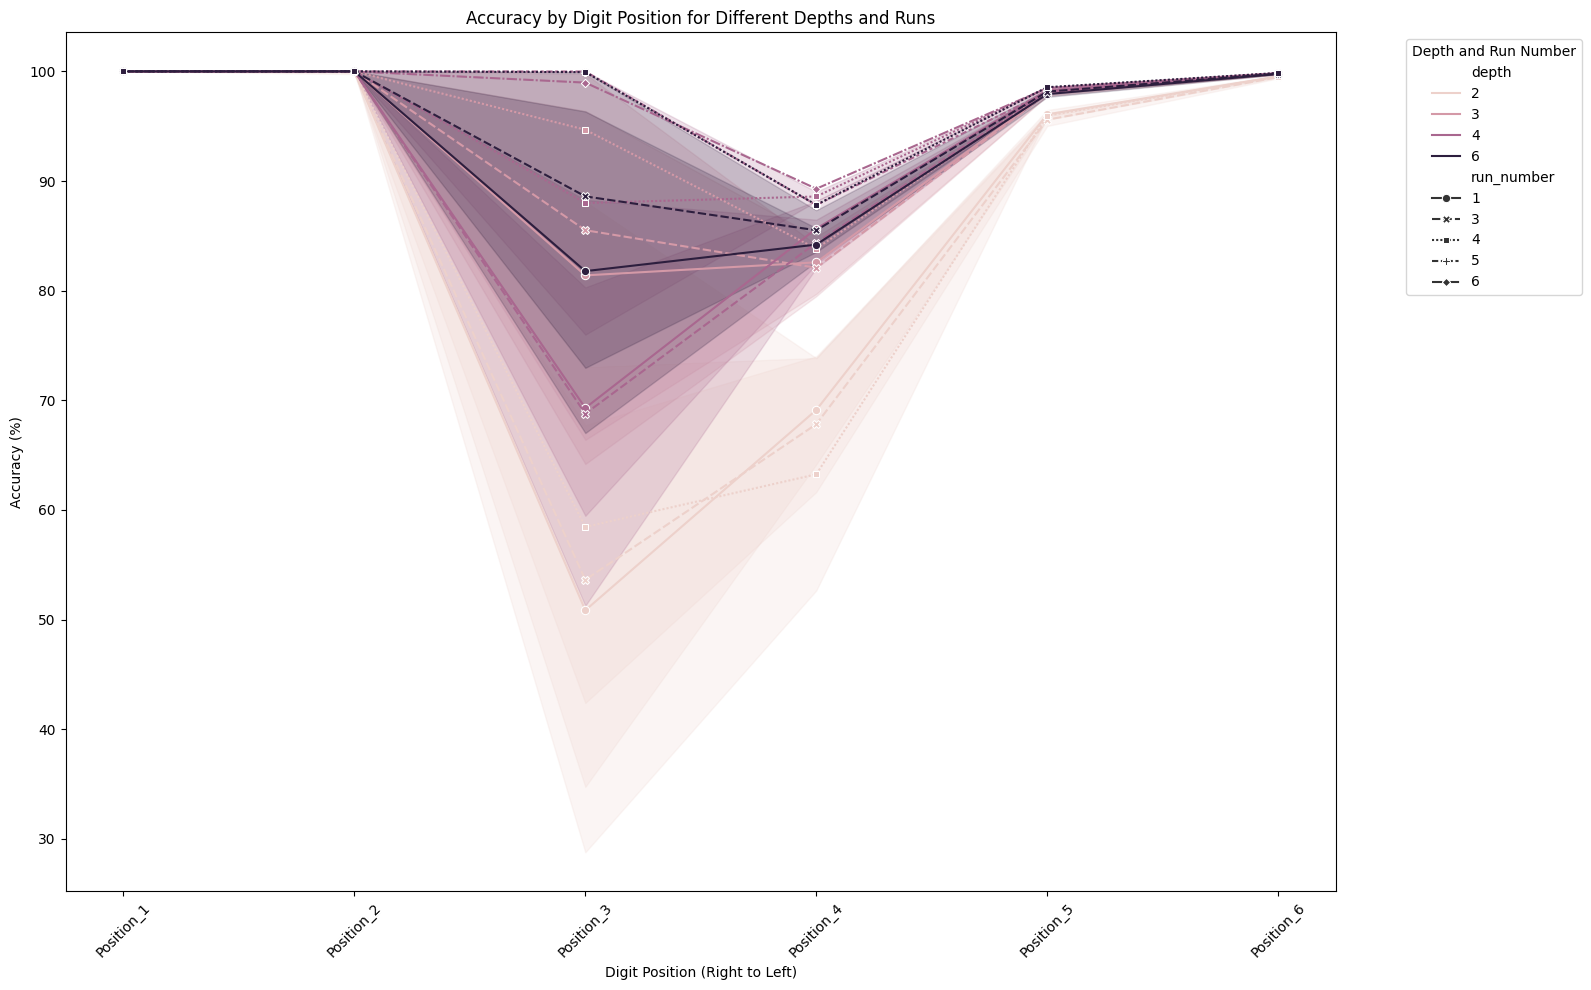

In [8]:
import numpy as np

# Function to get the digits at each position for each number in a list
def get_digits_at_positions(numbers):
    max_length = max([len(str(num)) for num in numbers])
    digits_at_positions = np.zeros((len(numbers), max_length), dtype=int)

    for i, num in enumerate(numbers):
        num_str = str(num).zfill(max_length)
        digits_at_positions[i, :] = [int(digit) for digit in num_str[::-1]]  # Reverse to get right-to-left

    return digits_at_positions

# Get the digits at each position for both Predictions and True Labels
pred_digits = get_digits_at_positions(df['Predictions'])
true_digits = get_digits_at_positions(df['True Labels'])

# Calculate the accuracy at each digit position
correct_digits = (pred_digits == true_digits).astype(int)
correct_digits_df = pd.DataFrame(correct_digits, columns=[f'Position_{i+1}' for i in range(correct_digits.shape[1])])

# Add the other relevant columns for grouping
correct_digits_df['tokens'] = df['tokens']
correct_digits_df['depth'] = df['depth']
correct_digits_df['run_number'] = df['run_number']

# Calculate the accuracy for each combination of position, tokens, depth, and run_number
accuracy_by_position_df = correct_digits_df.groupby(['tokens', 'depth', 'run_number']).mean().reset_index()
accuracy_by_position_df = accuracy_by_position_df.melt(id_vars=['tokens', 'depth', 'run_number'], 
                                                       value_vars=[col for col in correct_digits_df.columns if 'Position_' in col],
                                                       var_name='Digit_Position', value_name='Accuracy')

# Convert accuracy to percentage
accuracy_by_position_df['Accuracy'] *= 100

# Plot the data
plt.figure(figsize=(16, 10))
sns.lineplot(data=accuracy_by_position_df, x='Digit_Position', y='Accuracy', hue='depth', style='run_number', markers=True)
plt.title('Accuracy by Digit Position for Different Depths and Runs')
plt.xlabel('Digit Position (Right to Left)')
plt.ylabel('Accuracy (%)')
plt.legend(title='Depth and Run Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/4214869234.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/4214869234.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/4214869234.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/4214869234.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/4214869234.py:13: UserWarning: FixedFormatter should only be used together with

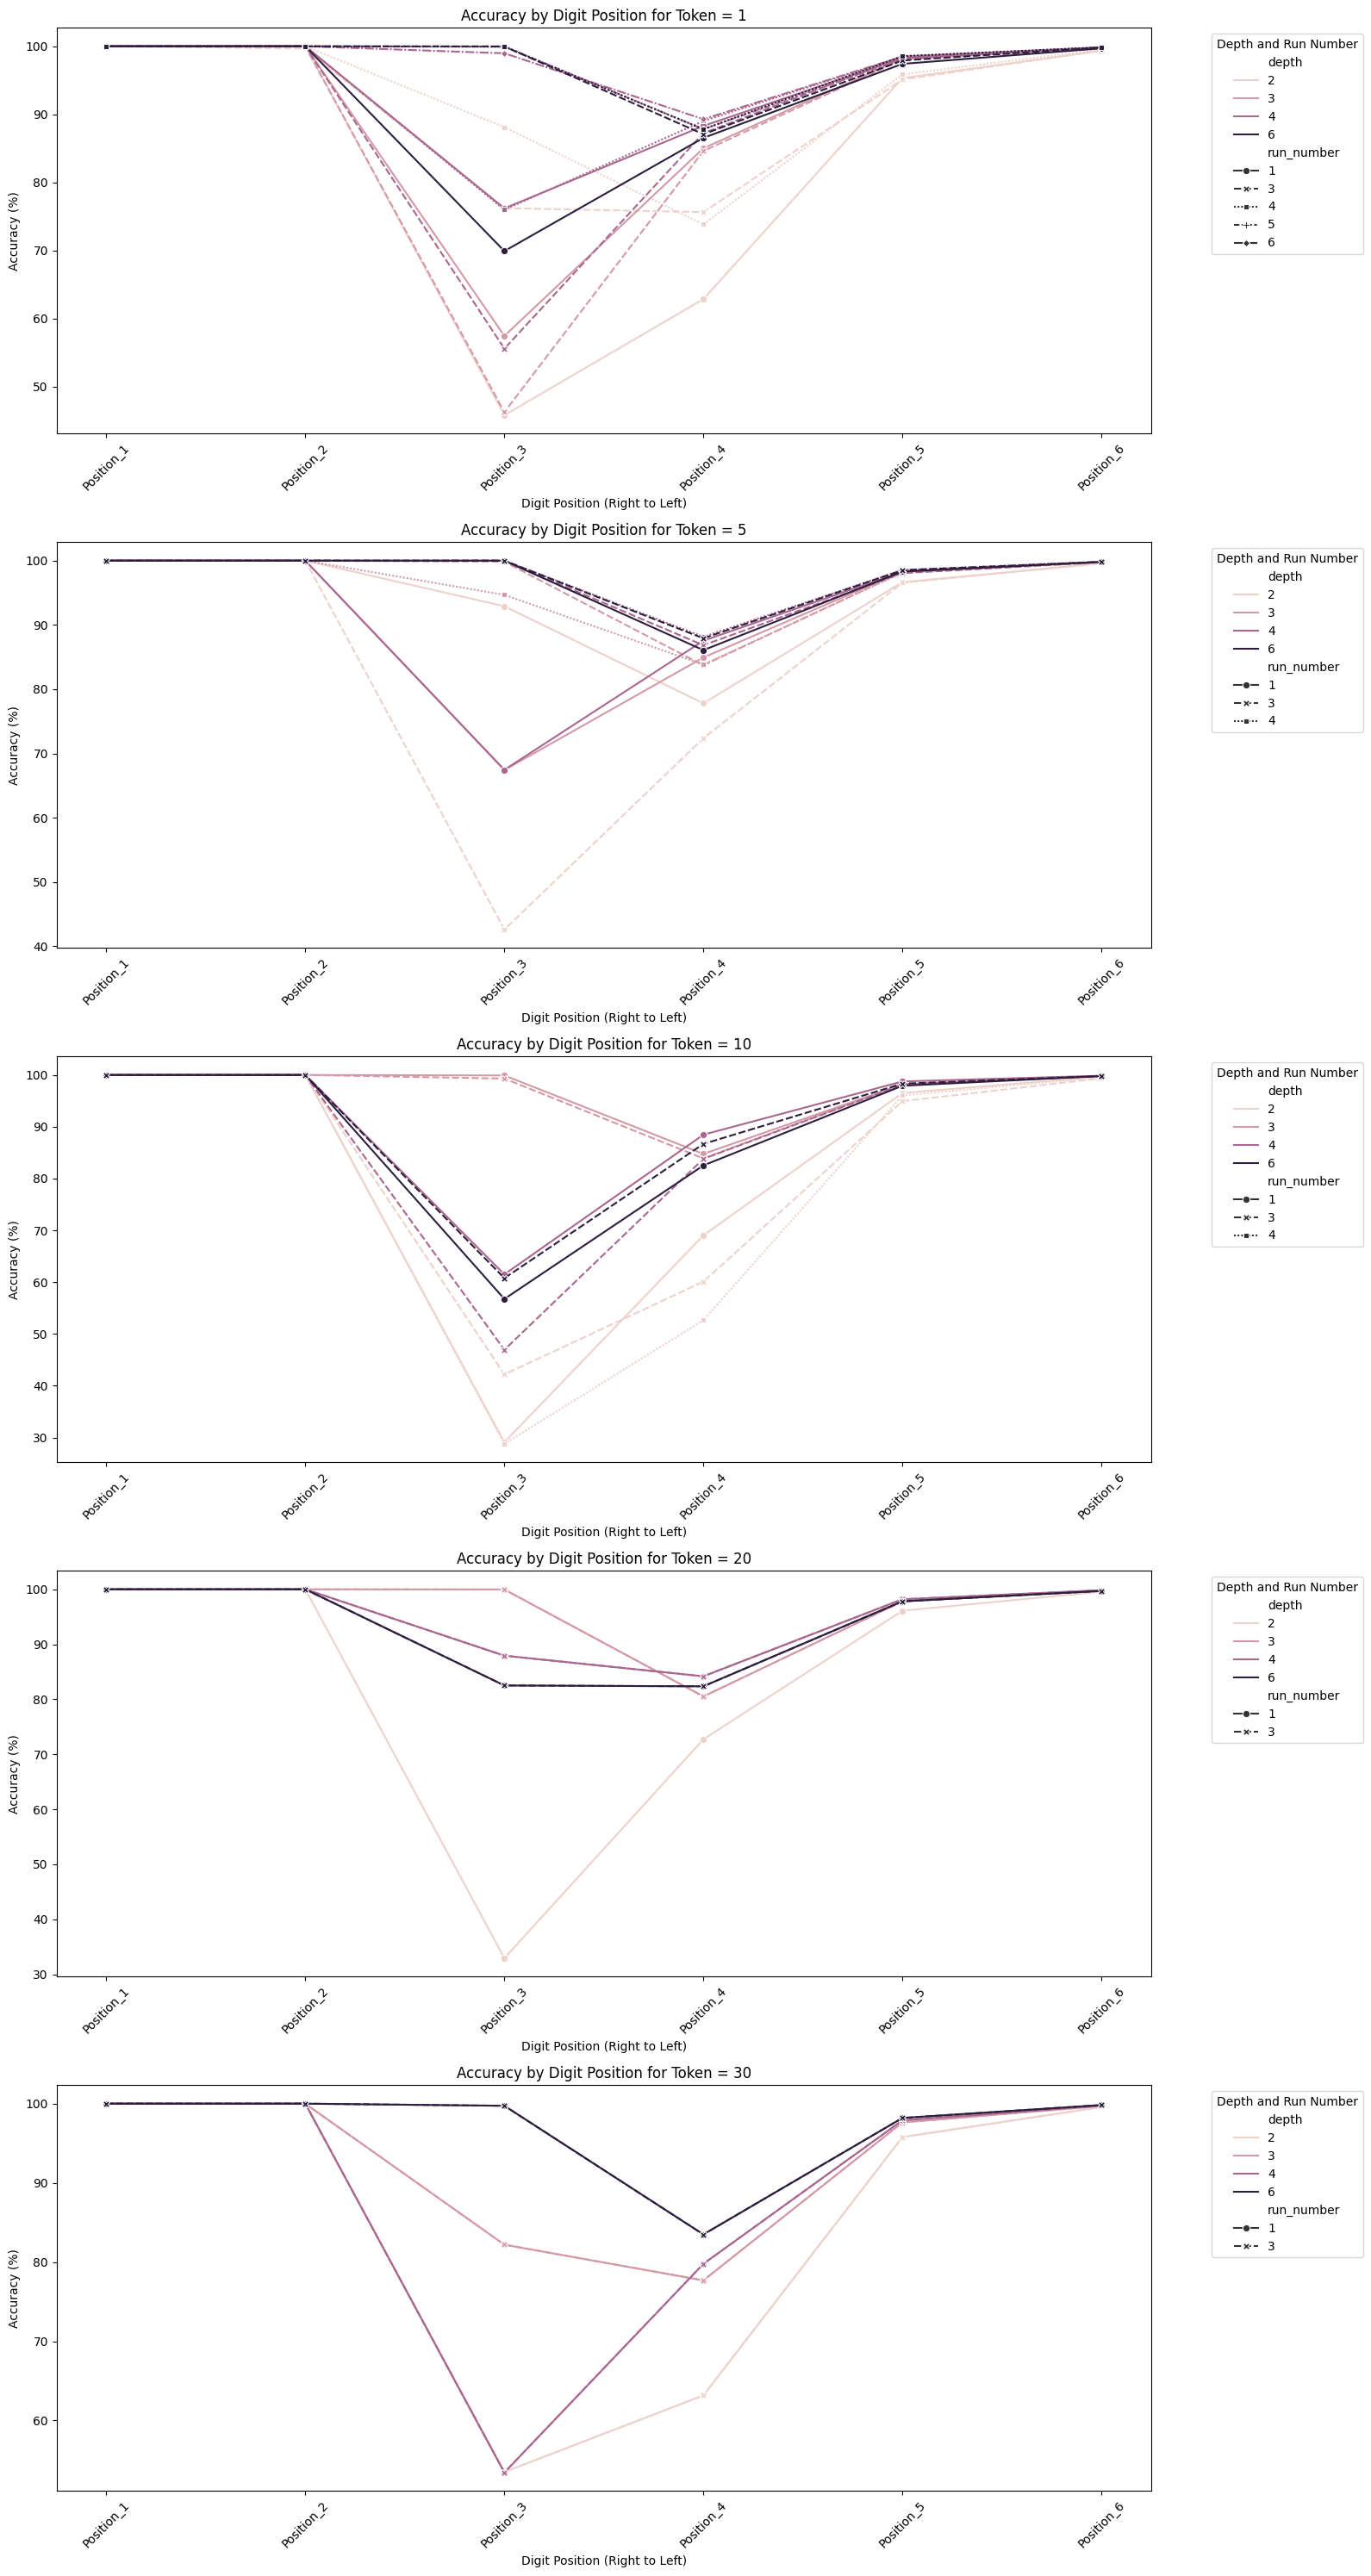

In [9]:
unique_tokens = accuracy_by_position_df['tokens'].unique()
n_plots = len(unique_tokens)
fig, axes = plt.subplots(n_plots, 1, figsize=(16, 6 * n_plots))

for i, token in enumerate(unique_tokens):
    ax = axes[i]
    sns.lineplot(data=accuracy_by_position_df[accuracy_by_position_df['tokens'] == token], 
                 x='Digit_Position', y='Accuracy', hue='depth', style='run_number', markers=True, ax=ax)
    ax.set_title(f'Accuracy by Digit Position for Token = {token}')
    ax.set_xlabel('Digit Position (Right to Left)')
    ax.set_ylabel('Accuracy (%)')
    ax.legend(title='Depth and Run Number', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/1215050399.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/1215050399.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/1215050399.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/1215050399.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


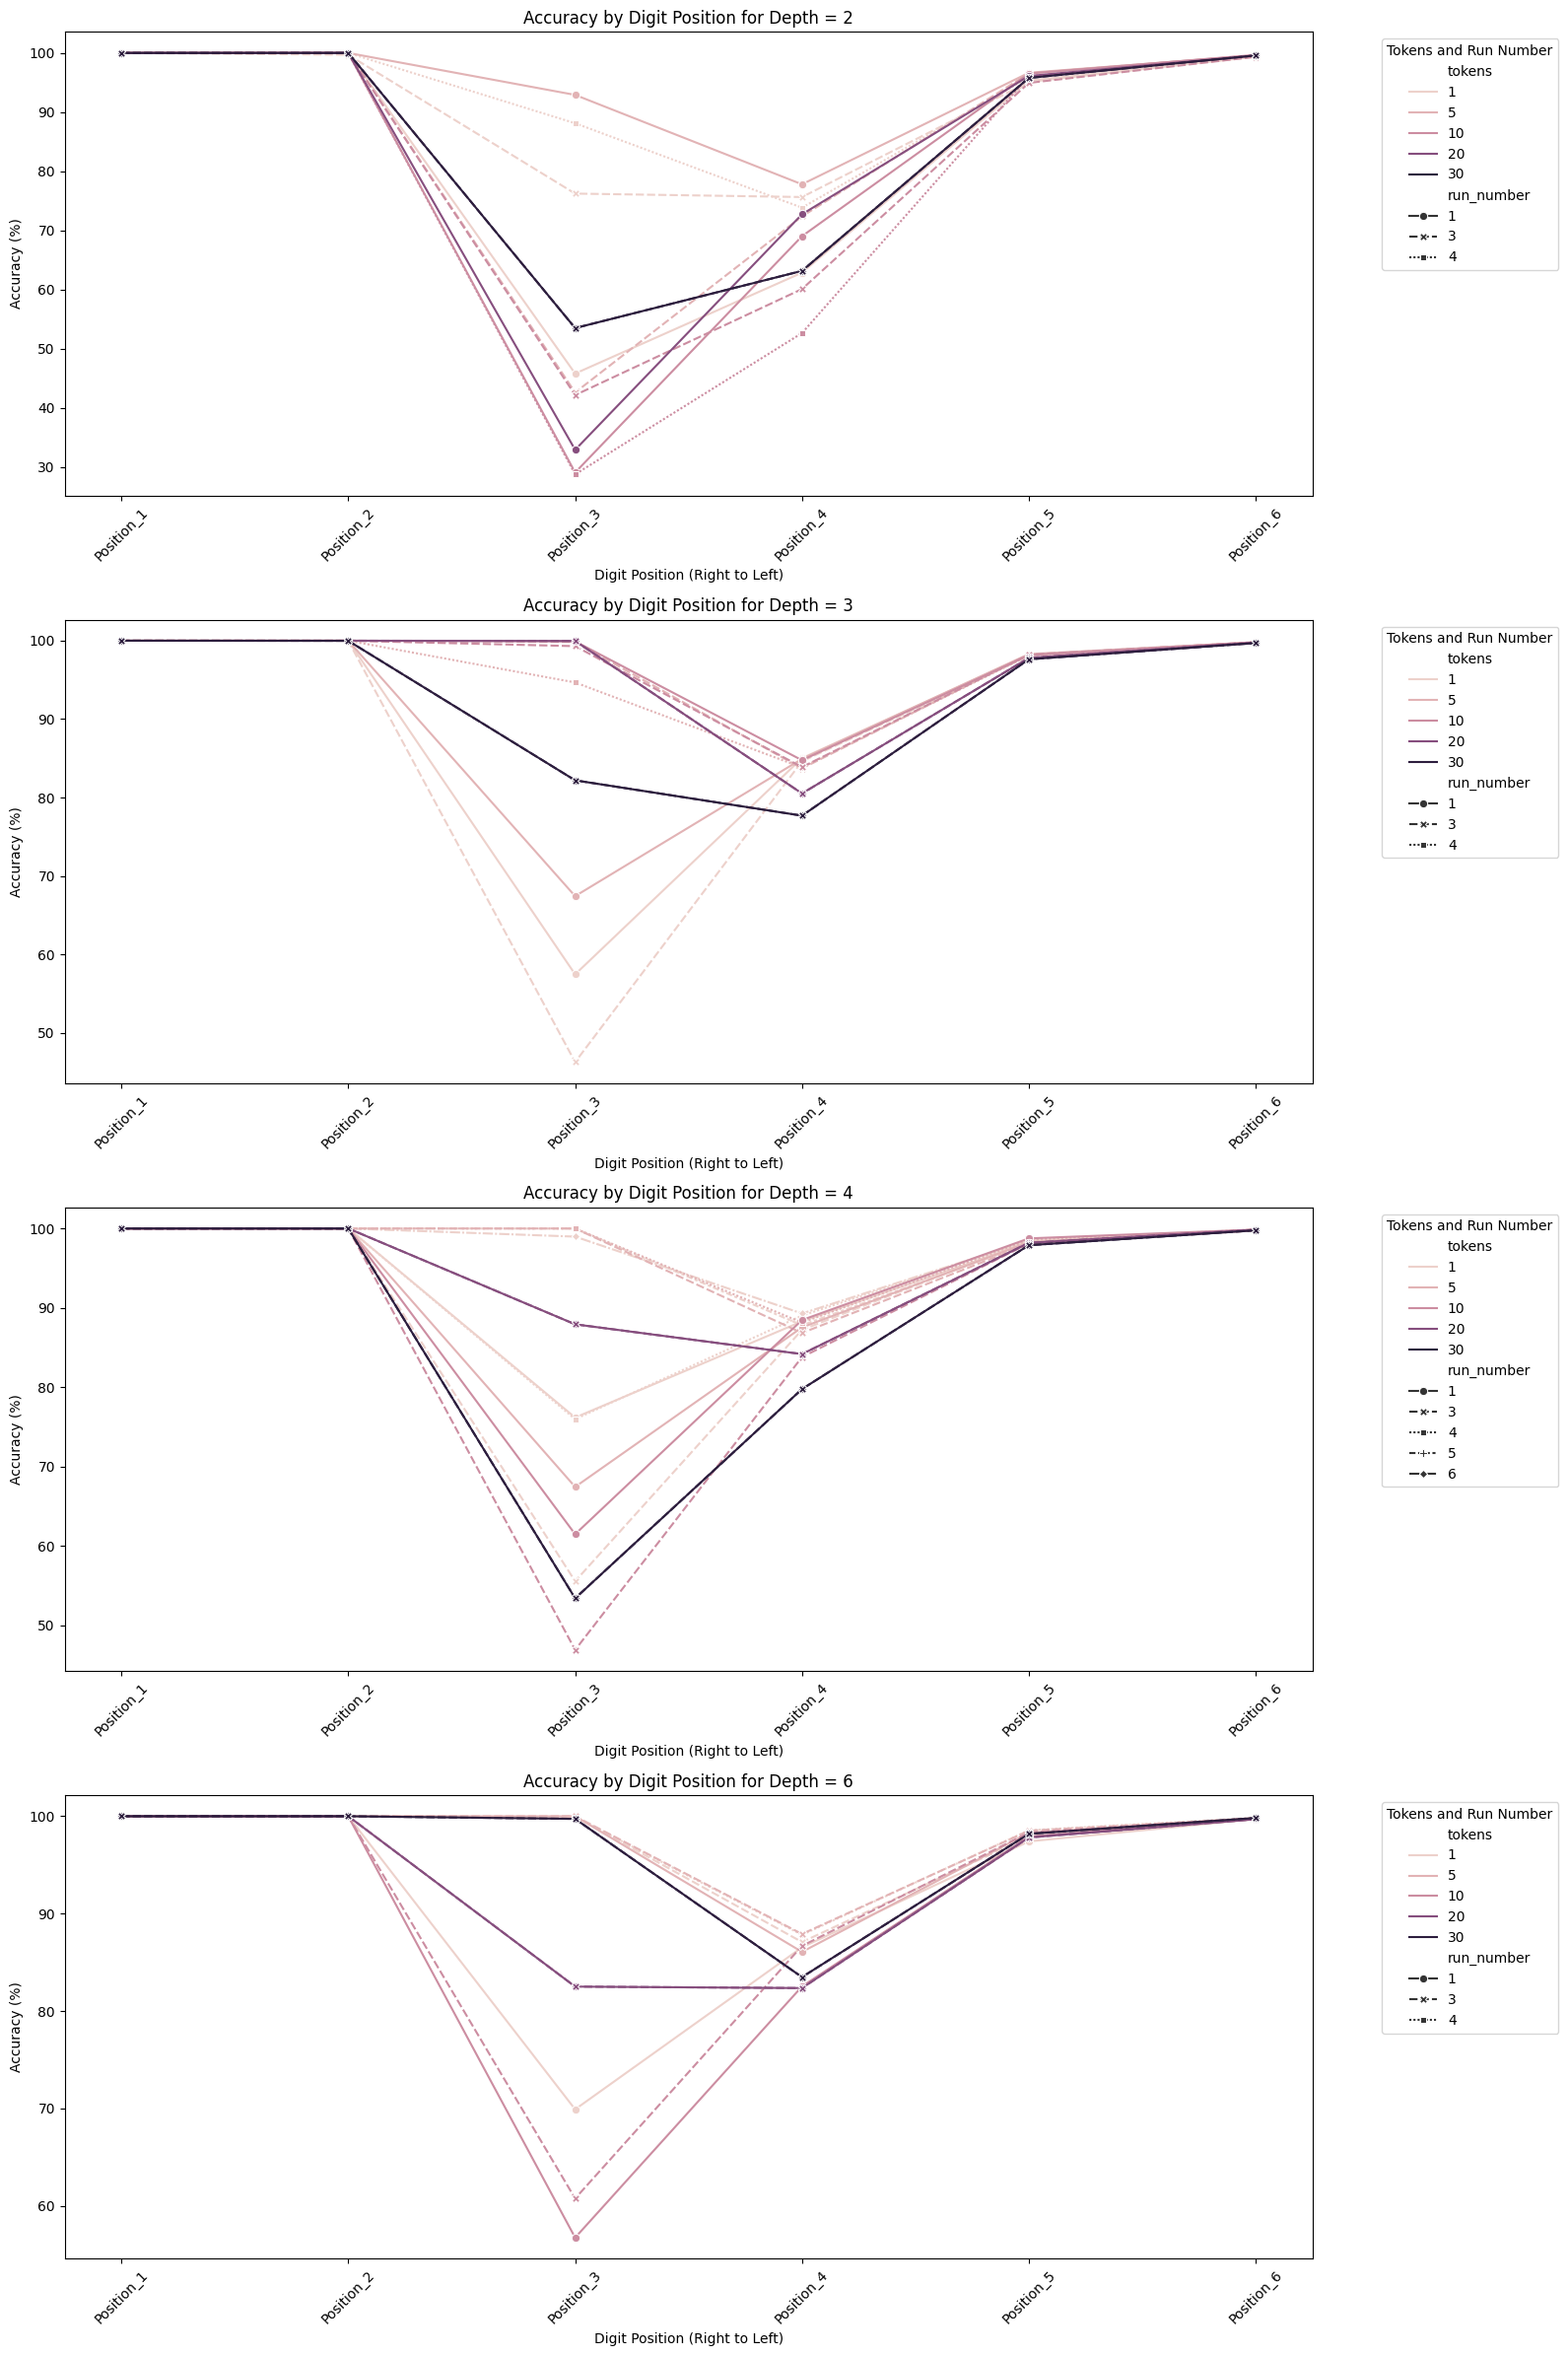

In [16]:
unique_depths = [2,3,4,6]
n_depths = len(unique_depths)
# Create subplots to differentiate by depth for the per-digit accuracy
fig, axes = plt.subplots(n_depths, 1, figsize=(16, 6 * n_depths))

for i, depth in enumerate(unique_depths):
    ax = axes[i]
    sns.lineplot(data=accuracy_by_position_df[accuracy_by_position_df['depth'] == depth], 
                 x='Digit_Position', y='Accuracy', hue='tokens', style='run_number', markers=True, ax=ax)
    ax.set_title(f'Accuracy by Digit Position for Depth = {depth}')
    ax.set_xlabel('Digit Position (Right to Left)')
    ax.set_ylabel('Accuracy (%)')
    ax.legend(title='Tokens and Run Number', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


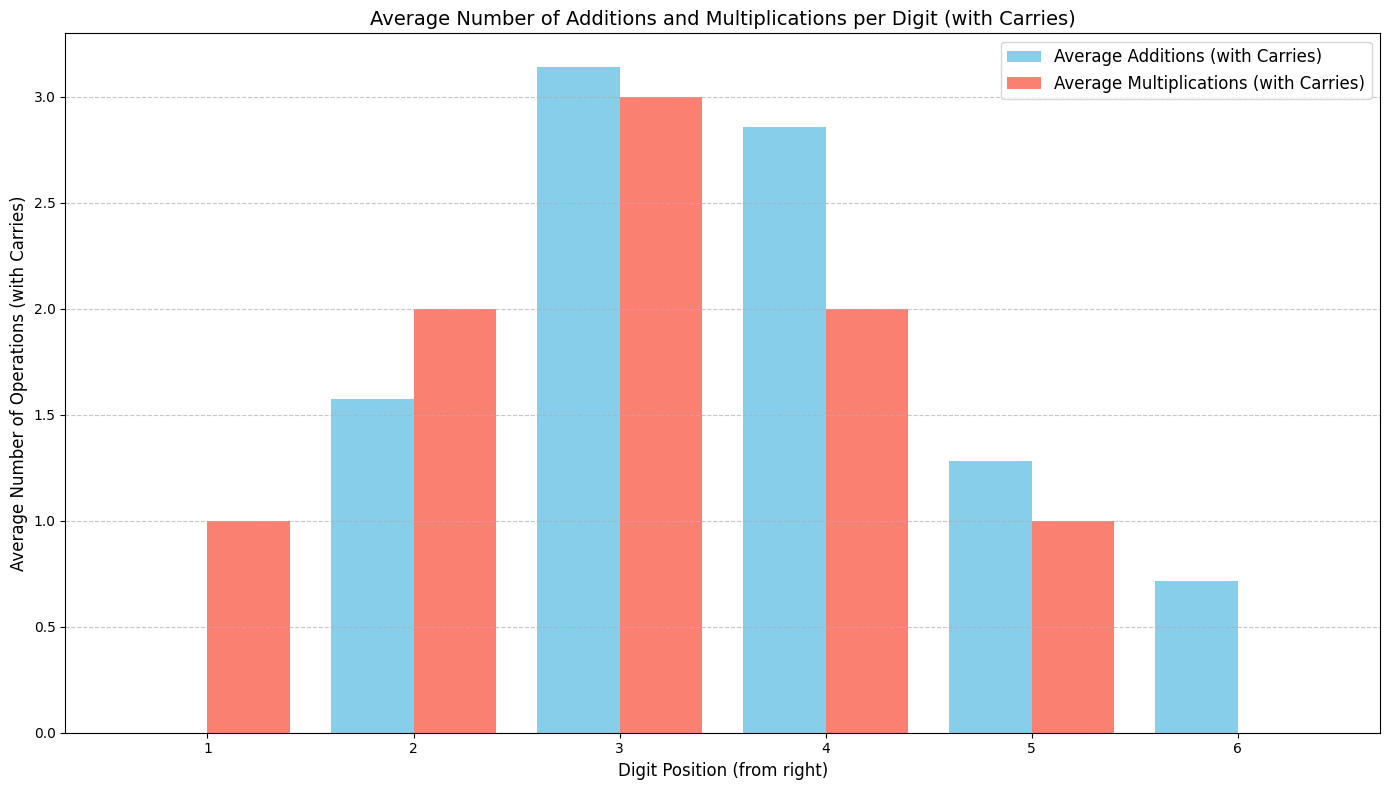

In [17]:
from collections import defaultdict

# Function to count operations per digit with carries
def count_operations_per_digit_with_carries(a, b):
    additions = defaultdict(int)
    multiplications = defaultdict(int)
    carry_additions = defaultdict(int)

    for i, digit_a in enumerate(reversed(str(a))):
        for j, digit_b in enumerate(reversed(str(b))):
            position = i + j + 1
            multiplications[position] += 1
            if multiplications[position] > 1:
                additions[position] += 1
            product = int(digit_a) * int(digit_b)
            carry = product // 10
            if carry > 0:
                carry_additions[position + 1] += 1

    for position, count in carry_additions.items():
        additions[position] += count

    return additions, multiplications

# Find the maximum number of digits in the product
max_digits_in_product = df['True Labels'].apply(lambda x: len(str(x))).max()

# Initialize counters
total_additions_with_carries = defaultdict(int)
total_multiplications_with_carries = defaultdict(int)
total_counts_with_carries = defaultdict(int)

# Calculate operations for all entries
for _, row in df.iterrows():
    n1, n2 = int(row['n1']), int(row['n2'])
    additions, multiplications = count_operations_per_digit_with_carries(n1, n2)
    for position in range(1, max_digits_in_product + 1):
        total_additions_with_carries[position] += additions.get(position, 0)
        total_multiplications_with_carries[position] += multiplications.get(position, 0)
        total_counts_with_carries[position] += 1

# Calculate average operations per digit position
avg_additions_with_carries = {position: total / total_counts_with_carries[position] for position, total in total_additions_with_carries.items()}
avg_multiplications_with_carries = {position: total / total_counts_with_carries[position] for position, total in total_multiplications_with_carries.items()}

# Sort data for plotting
sorted_positions_with_carries = sorted(avg_additions_with_carries.keys())
sorted_avg_additions_with_carries = [avg_additions_with_carries[pos] for pos in sorted_positions_with_carries]
sorted_avg_multiplications_with_carries = [avg_multiplications_with_carries.get(pos, 0) for pos in sorted_positions_with_carries]

# Plot the data with a consistent theme
plt.figure(figsize=(14, 8))
plt.bar(np.arange(len(sorted_positions_with_carries)) - 0.2, sorted_avg_additions_with_carries, 0.4, label='Average Additions (with Carries)', color='skyblue')
plt.bar(np.arange(len(sorted_positions_with_carries)) + 0.2, sorted_avg_multiplications_with_carries, 0.4, label='Average Multiplications (with Carries)', color='salmon')
plt.xlabel('Digit Position (from right)', fontsize=12)
plt.ylabel('Average Number of Operations (with Carries)', fontsize=12)
plt.title('Average Number of Additions and Multiplications per Digit (with Carries)', fontsize=14)
plt.xticks(np.arange(len(sorted_positions_with_carries)), sorted_positions_with_carries, fontsize=10)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

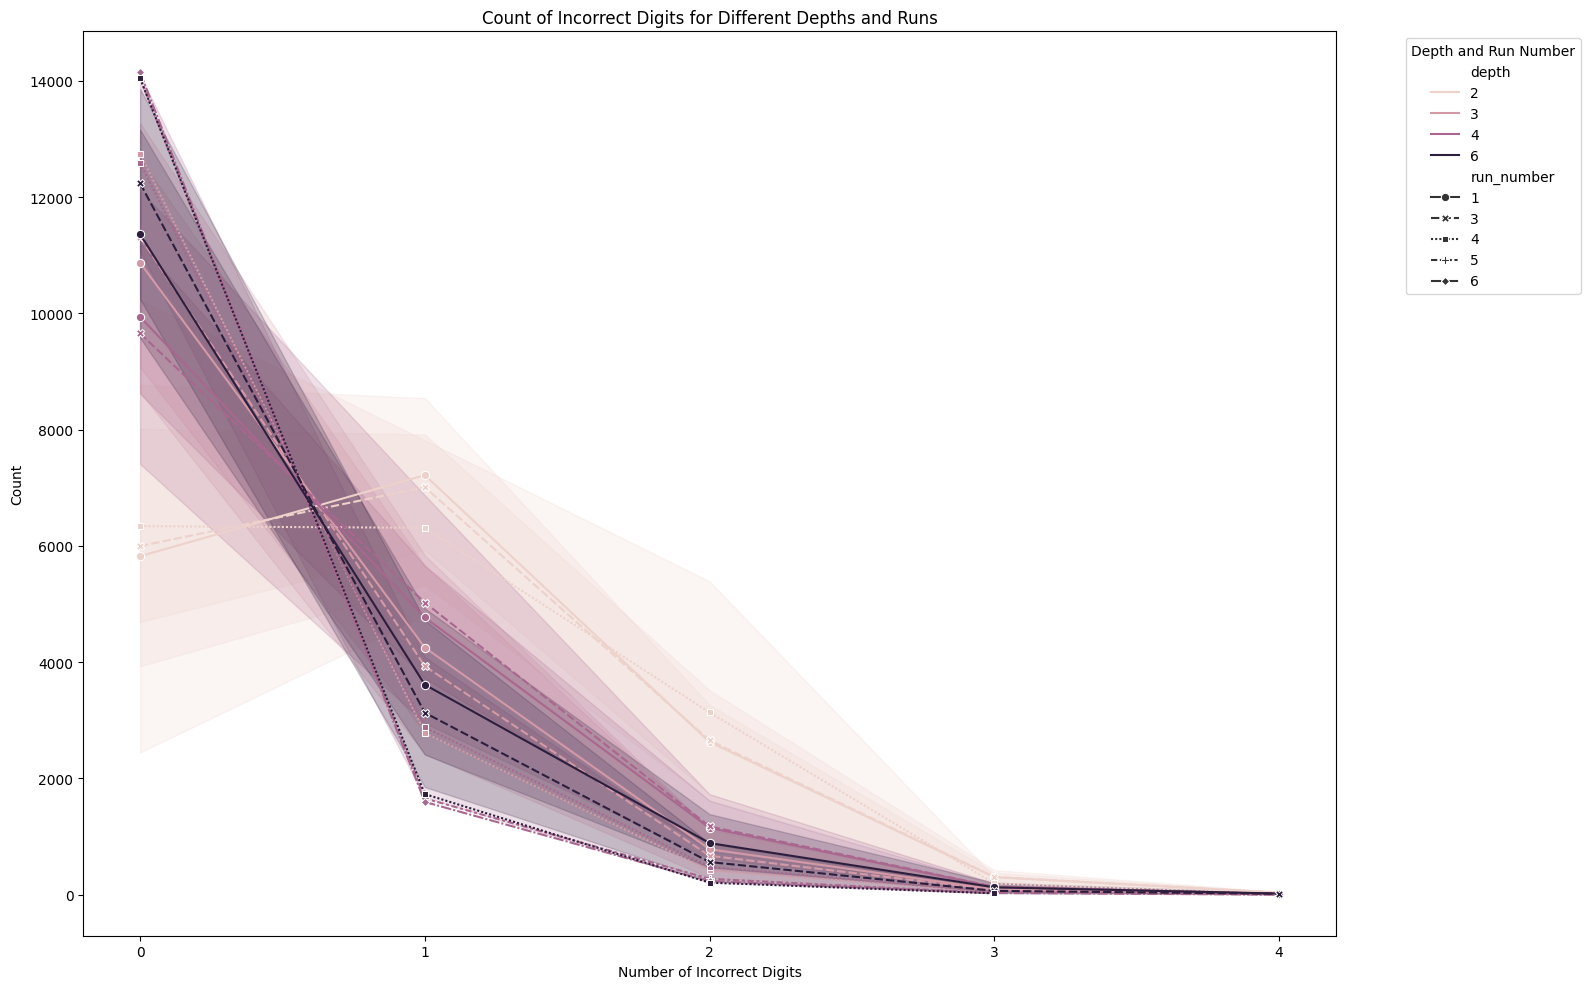

In [18]:
# Calculate the number of incorrect digits for each row
incorrect_digits_count = np.sum(pred_digits != true_digits, axis=1)

# Create a DataFrame to store this information along with tokens, depth, and run_number
incorrect_digits_df = pd.DataFrame({
    'Incorrect_Digits': incorrect_digits_count,
    'tokens': df['tokens'],
    'depth': df['depth'],
    'run_number': df['run_number']
})

# Count how many times each method is off by 1, 2, 3, etc. digits
incorrect_count_df = incorrect_digits_df.groupby(['Incorrect_Digits', 'tokens', 'depth', 'run_number']).size().reset_index(name='Count')

# Plot the data
plt.figure(figsize=(16, 10))
sns.lineplot(data=incorrect_count_df, x='Incorrect_Digits', y='Count', hue='depth', style='run_number', markers=True)
plt.title('Count of Incorrect Digits for Different Depths and Runs')
plt.xlabel('Number of Incorrect Digits')
plt.ylabel('Count')
plt.legend(title='Depth and Run Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(np.arange(min(incorrect_count_df['Incorrect_Digits']), max(incorrect_count_df['Incorrect_Digits']) + 1, 1))
plt.tight_layout()
plt.show()


/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/2983536856.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/2983536856.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/2983536856.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/f9/8vyp0c5d4q3_c6pq2w2vxrv00000gn/T/ipykernel_96824/2983536856.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


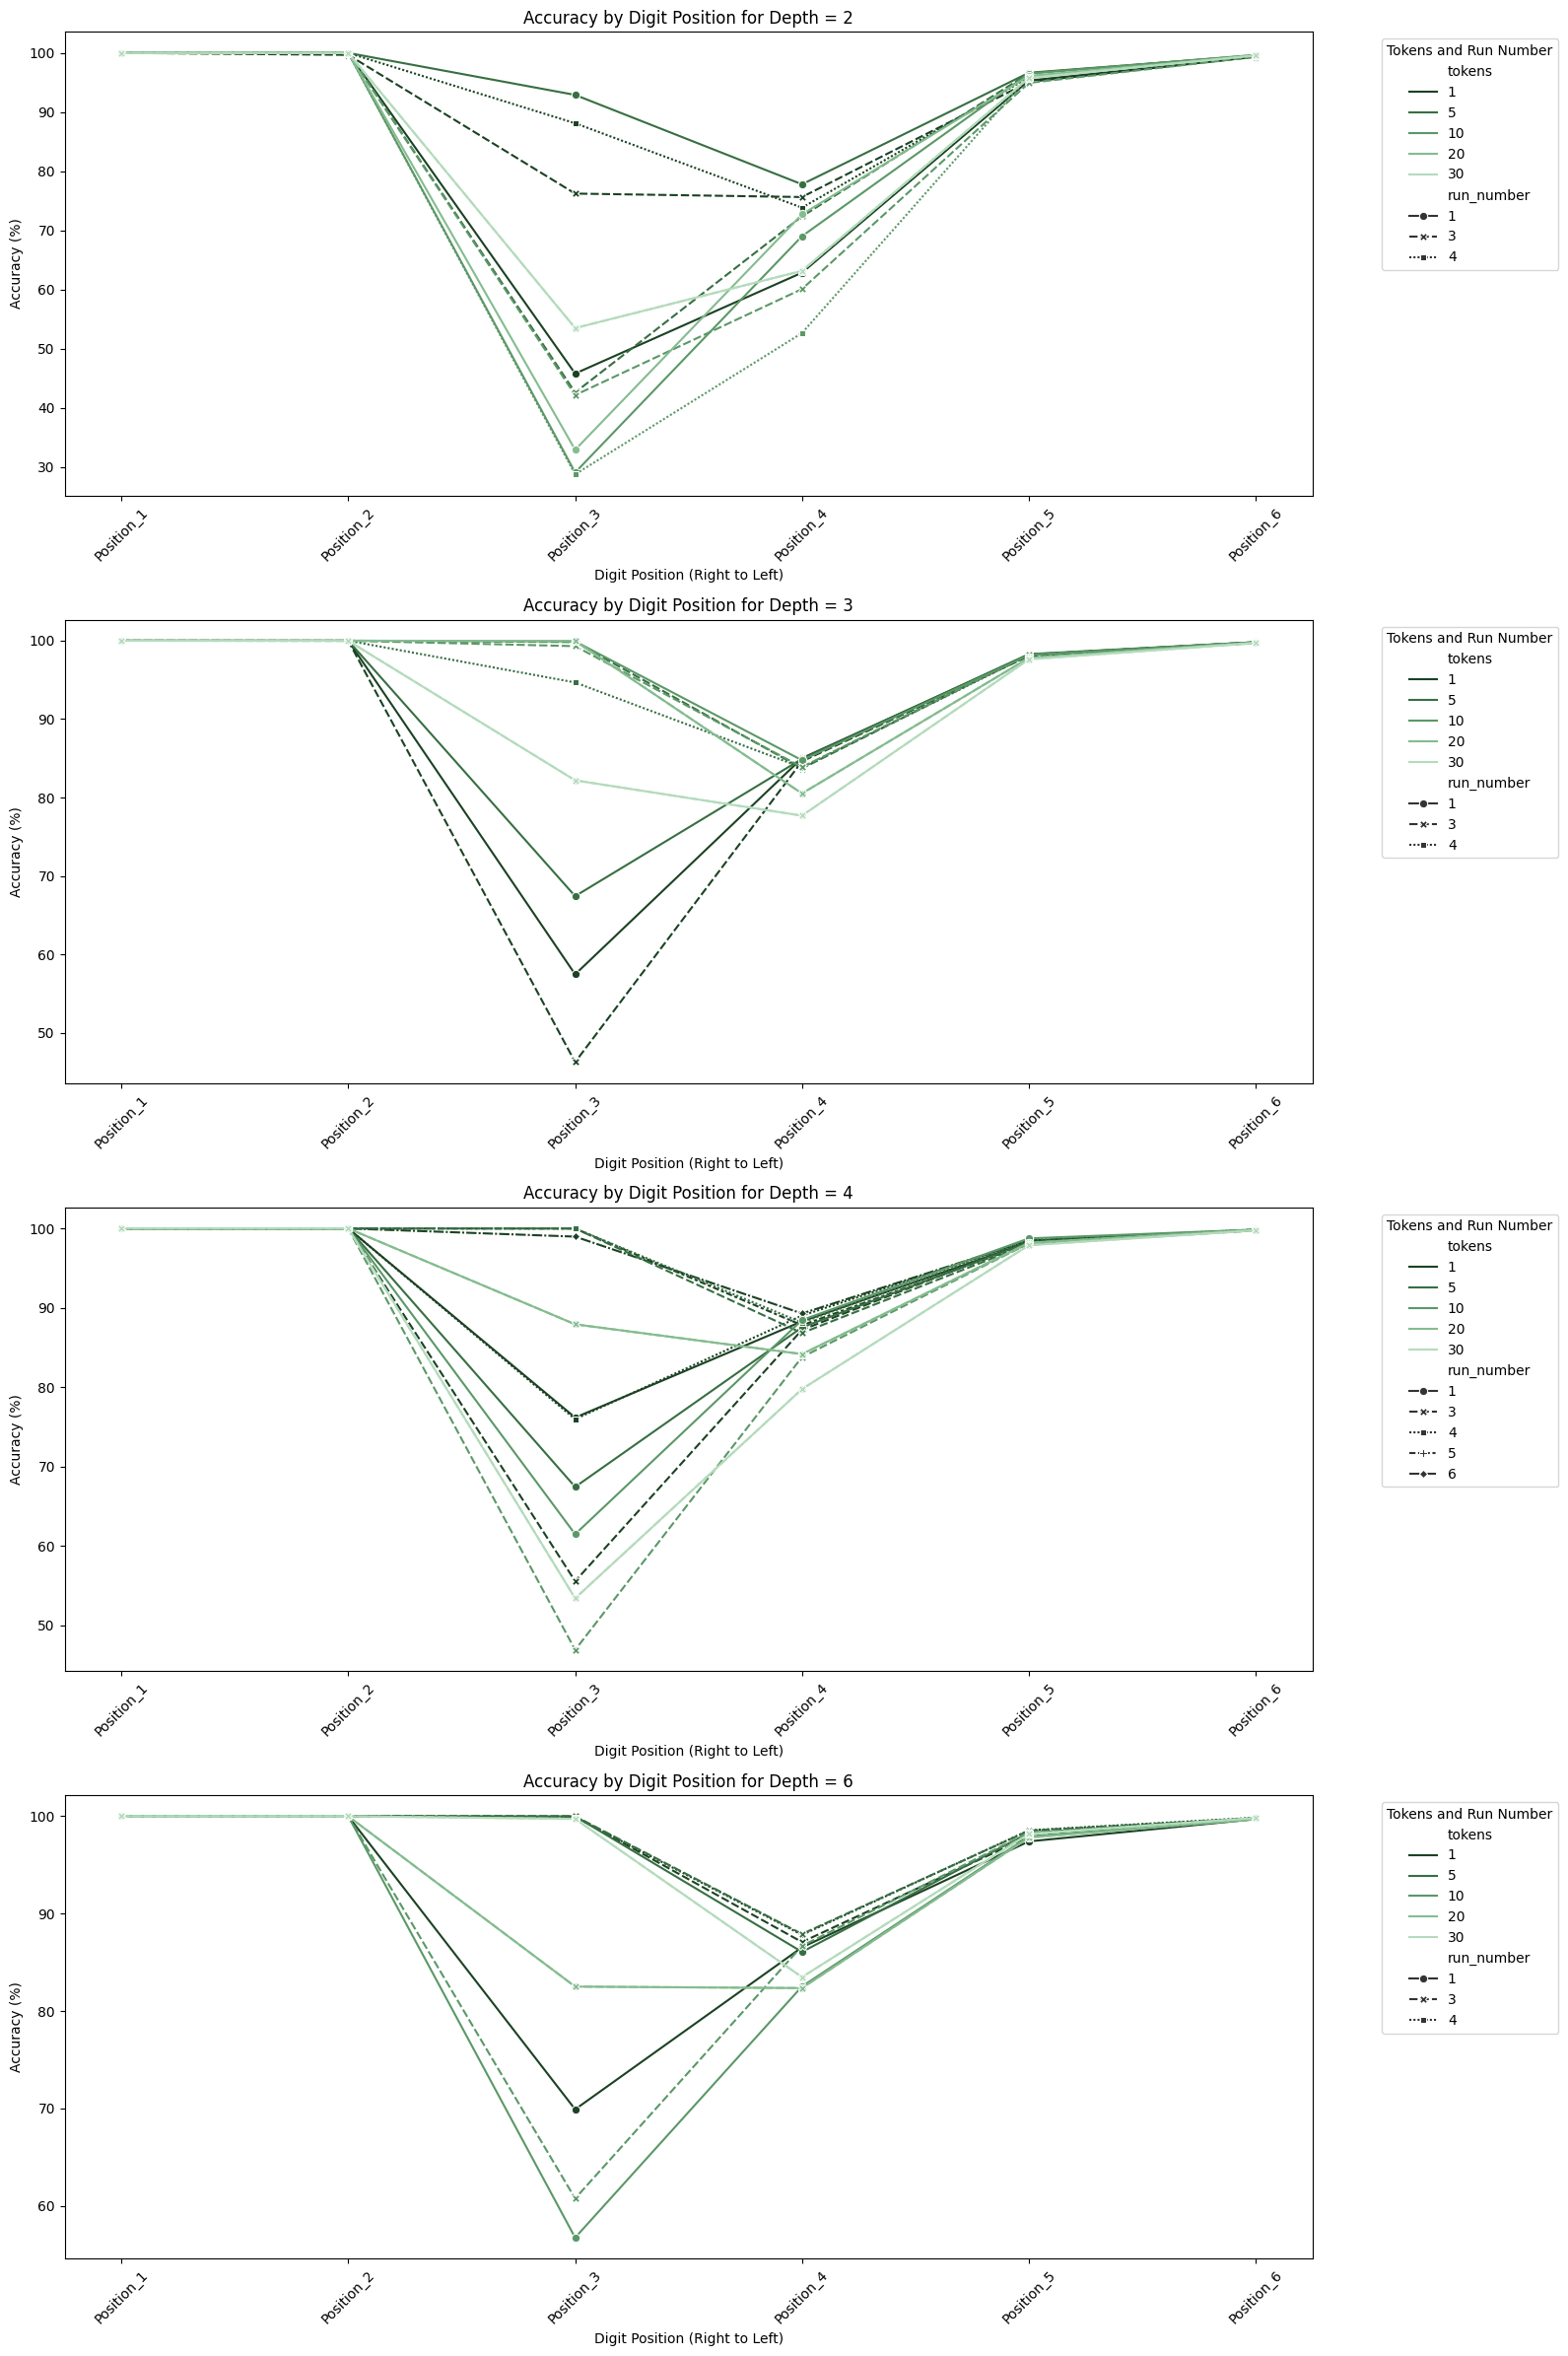

In [19]:
# Now, regenerate the graph for the per-digit accuracy separated by depth using adjusted color palette.

# Function to generate the plot for each depth for per-digit accuracy
def plot_accuracy_by_depth(data, ax):
    unique_tokens_for_depth = data['tokens'].unique()
    gradient_palette_for_depth = sns.cubehelix_palette(n_colors=len(unique_tokens_for_depth), start=2, rot=0, dark=0.2, light=0.8, reverse=True)
    sns.lineplot(data=data, x='Digit_Position', y='Accuracy', hue='tokens', style='run_number', markers=True, ax=ax, palette=gradient_palette_for_depth)
    ax.set_title(f'Accuracy by Digit Position for Depth = {data["depth"].iloc[0]}')
    ax.set_xlabel('Digit Position (Right to Left)')
    ax.set_ylabel('Accuracy (%)')
    ax.legend(title='Tokens and Run Number', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

fig, axes = plt.subplots(n_depths, 1, figsize=(16, 6 * n_depths))
for i, (depth, group_data) in enumerate(accuracy_by_position_df.groupby('depth')):
    plot_accuracy_by_depth(group_data, axes[i])
    axes[i].set_xticks(range(len(group_data['Digit_Position'].unique())))  # Set x-ticks to ensure labels are displayed
    axes[i].set_xticklabels(group_data['Digit_Position'].unique(), rotation=45)  # Set the x-axis labels

plt.tight_layout()
plt.show()


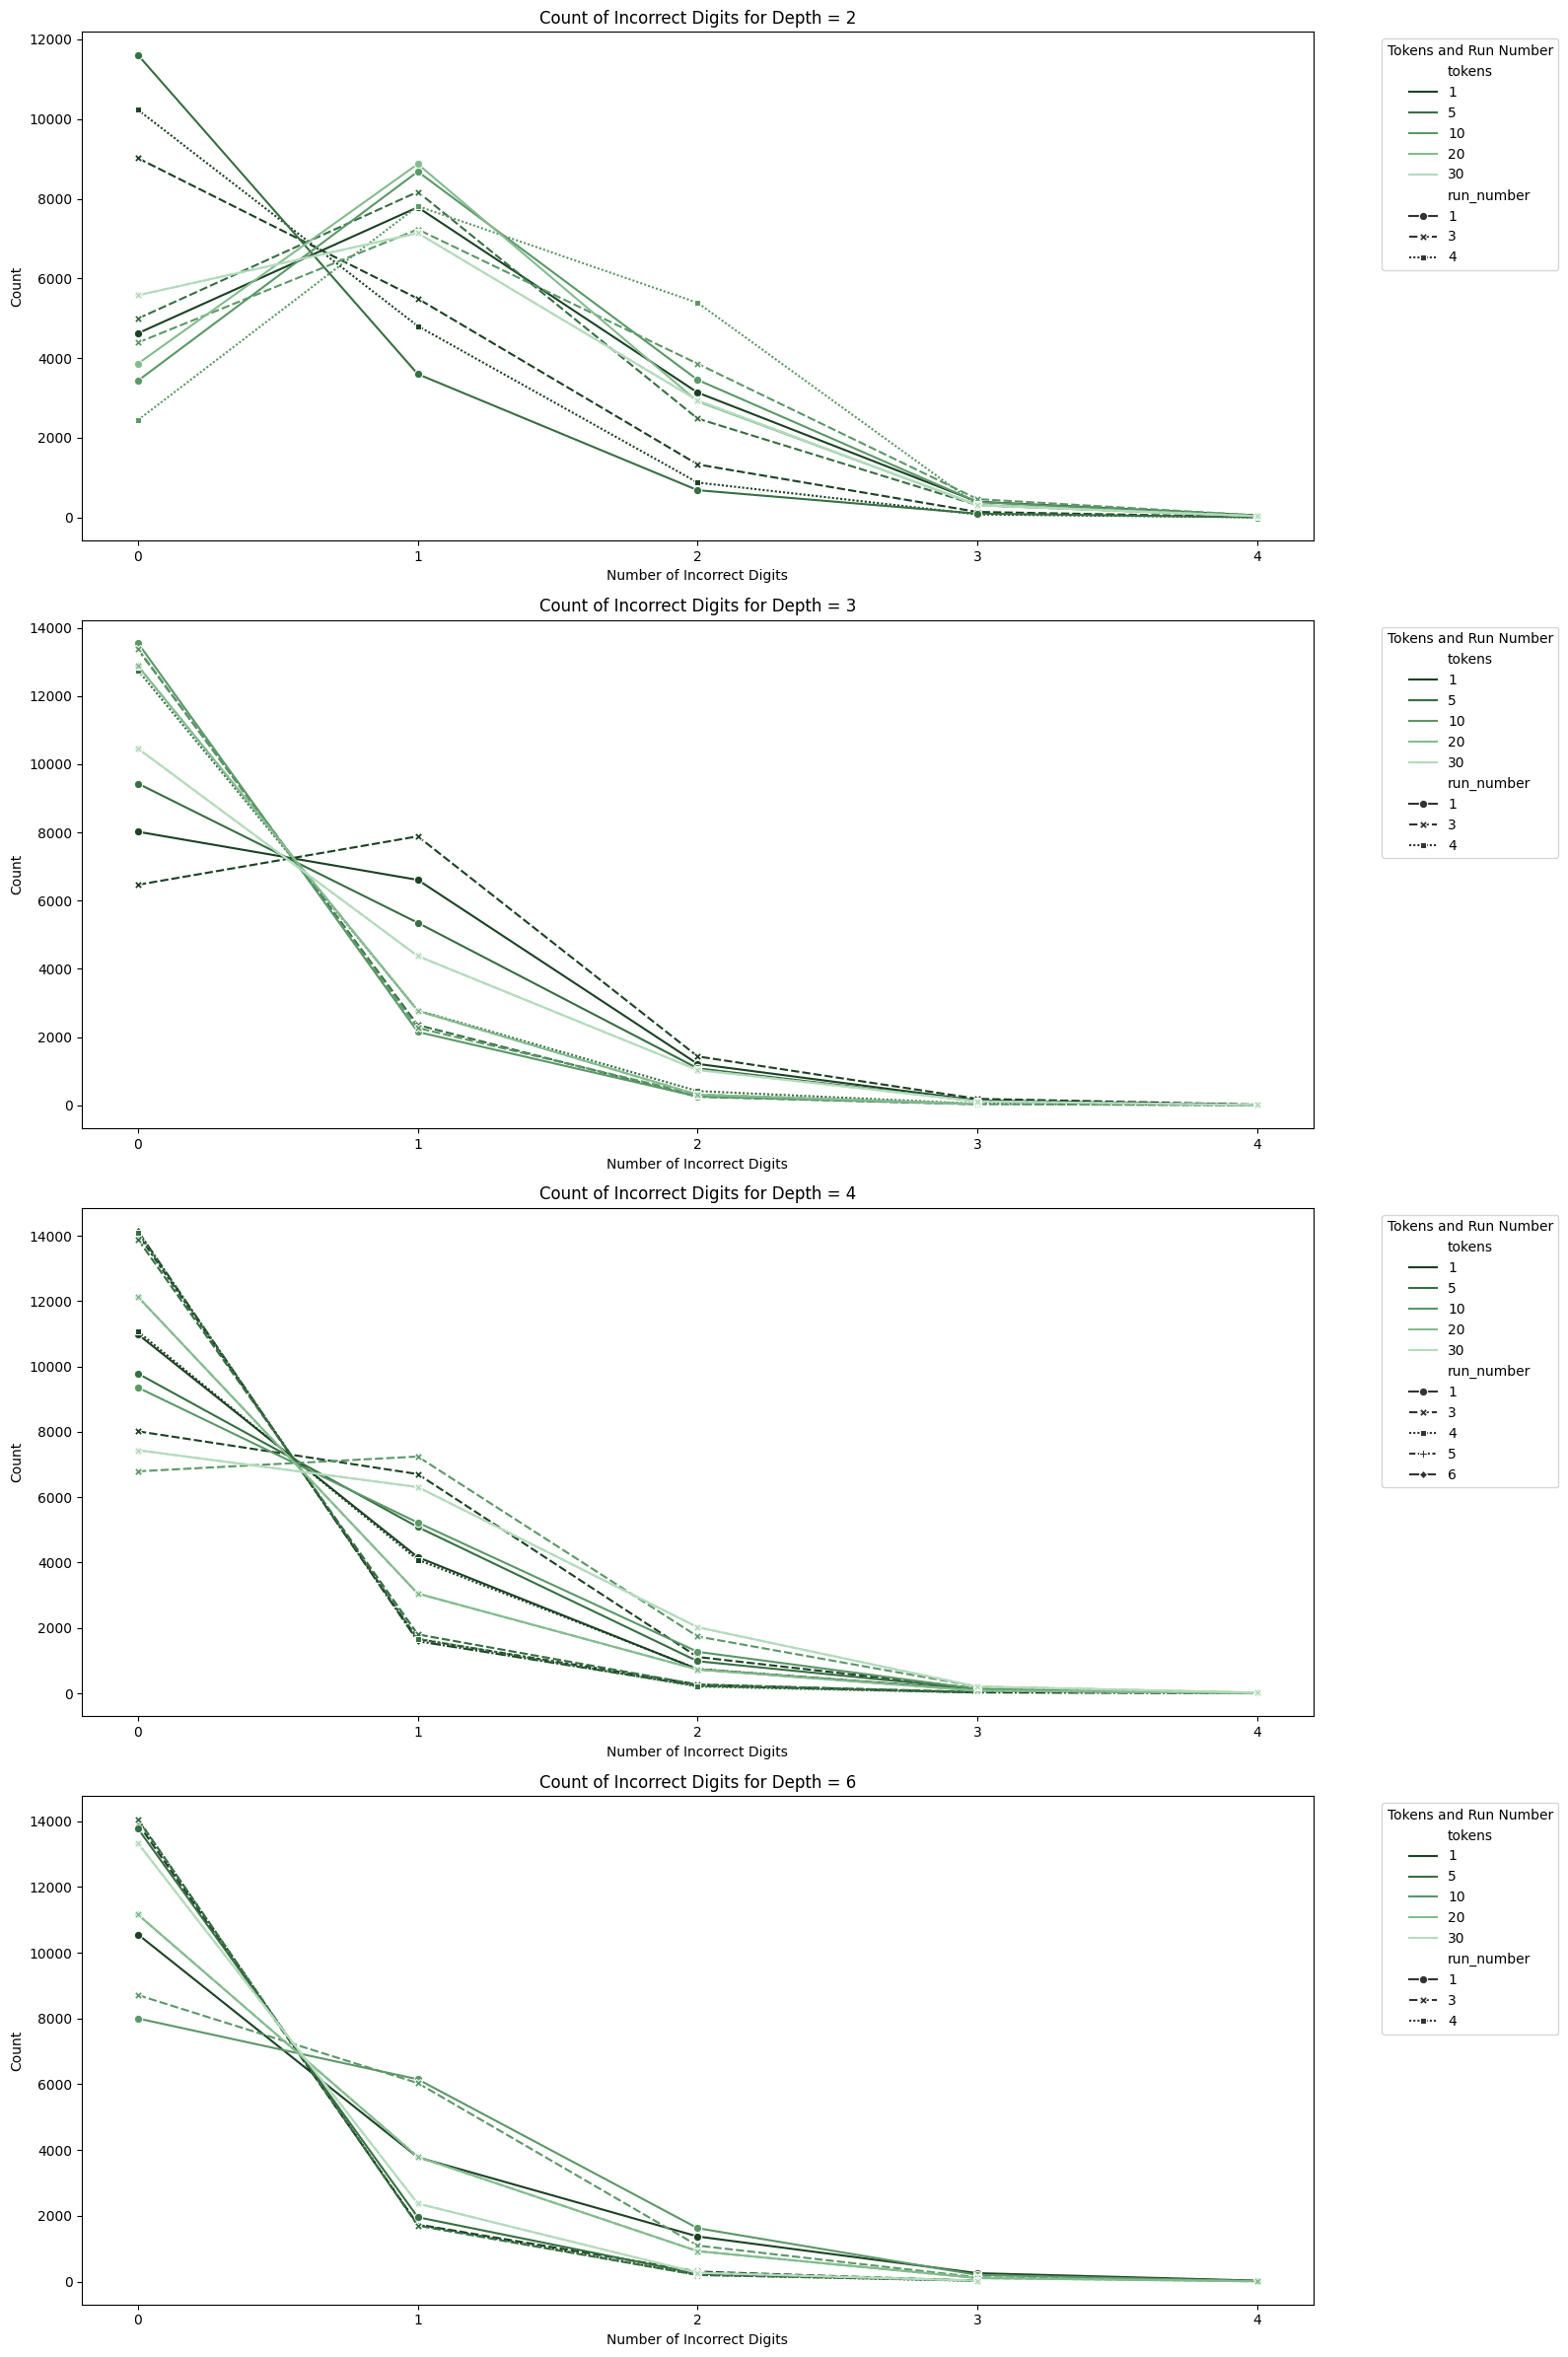

In [20]:
# Regenerate the graph for the count of incorrect digits, separated by the depth with adjusted color palette.

# Function to generate the plot for each depth
def plot_by_depth(data, y_value, title_prefix, ax):
    unique_tokens_for_depth = data['tokens'].unique()
    gradient_palette_for_depth = sns.cubehelix_palette(n_colors=len(unique_tokens_for_depth), start=2, rot=0, dark=0.2, light=0.8, reverse=True)
    sns.lineplot(data=data, x='Incorrect_Digits', y=y_value, hue='tokens', style='run_number', markers=True, ax=ax, palette=gradient_palette_for_depth)
    ax.set_title(f'{title_prefix} for Depth = {data["depth"].iloc[0]}')
    ax.set_xlabel('Number of Incorrect Digits')
    ax.set_ylabel(y_value)
    ax.legend(title='Tokens and Run Number', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticks(np.arange(min(data['Incorrect_Digits']), max(data['Incorrect_Digits']) + 1, 1))

fig, axes = plt.subplots(n_depths, 1, figsize=(16, 6 * n_depths))
for i, (depth, group_data) in enumerate(incorrect_count_df.groupby('depth')):
    plot_by_depth(group_data, 'Count', 'Count of Incorrect Digits', axes[i])
plt.tight_layout()
plt.show()


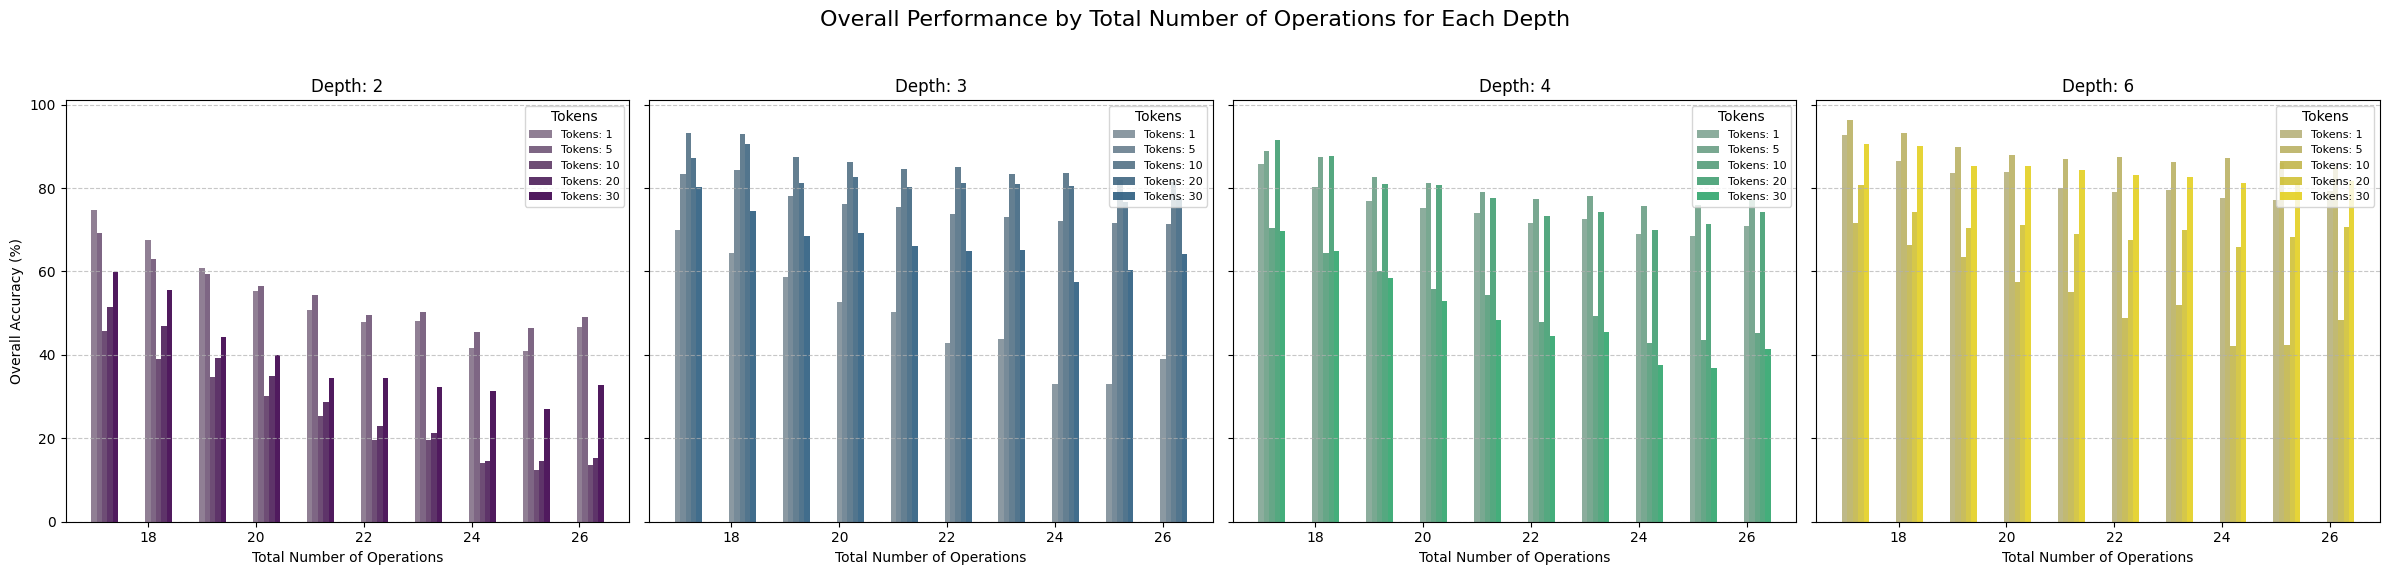

In [21]:
# Reload the CSV file into a DataFrame
# df = pd.read_csv(file_path)

# Calculate the accuracy for each row
df['Correct'] = (df['Predictions'] == df['True Labels']).astype(int)

# Function to count total operations for the entire multiplication
def count_total_operations_fresh(a, b):
    additions = 0
    multiplications = 0

    for i, digit_a in enumerate(reversed(str(a))):
        for j, digit_b in enumerate(reversed(str(b))):
            multiplications += 1
            if multiplications > 1:
                additions += 1
            product = int(digit_a) * int(digit_b)
            carry = product // 10
            if carry > 0:
                additions += 1

    return additions + multiplications

# Apply the function to each row to get the total number of operations for the entire multiplication
df['Total_Operations'] = df.apply(lambda row: count_total_operations_fresh(int(row['n1']), int(row['n2'])), axis=1)

# Group data by the total number of operations, tokens, and depth, then calculate the mean overall accuracy
grouped_overall_df_fresh = df.groupby(['Total_Operations', 'tokens', 'depth']).agg({'Correct': 'mean'}).reset_index()
grouped_overall_df_fresh['Overall_Accuracy'] = grouped_overall_df_fresh['Correct'] * 100  # Convert to percentage

# Create a grid of plots, one for each unique depth
unique_depths_fresh = sorted(grouped_overall_df_fresh['depth'].unique())
unique_tokens_fresh = sorted(grouped_overall_df_fresh['tokens'].unique())
base_colors_fresh = plt.cm.viridis(np.linspace(0, 1, len(unique_depths_fresh)))

fig, axes = plt.subplots(nrows=1, ncols=len(unique_depths_fresh), figsize=(24, 6), sharey=True)

# Plotting
for i, depth in enumerate(unique_depths_fresh):
    ax = axes[i]
    sub_df_depth = grouped_overall_df_fresh[grouped_overall_df_fresh['depth'] == depth]
    
    for j, tokens in enumerate(unique_tokens_fresh):
        gradient_color = base_colors_fresh[i] * (0.5 + j * 0.5 / len(unique_tokens_fresh))
        sub_df = sub_df_depth[sub_df_depth['tokens'] == tokens]
        ax.bar(sub_df['Total_Operations'] + j * 0.1, sub_df['Overall_Accuracy'], 
               width=0.1, label=f"Tokens: {tokens}", color=gradient_color)
    
    # Labeling and styling for each subplot
    ax.set_title(f'Depth: {depth}')
    ax.set_xlabel('Total Number of Operations')
    if i == 0:
        ax.set_ylabel('Overall Accuracy (%)')
    ax.legend(title='Tokens', fontsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Overall title and layout
plt.suptitle('Overall Performance by Total Number of Operations for Each Depth', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


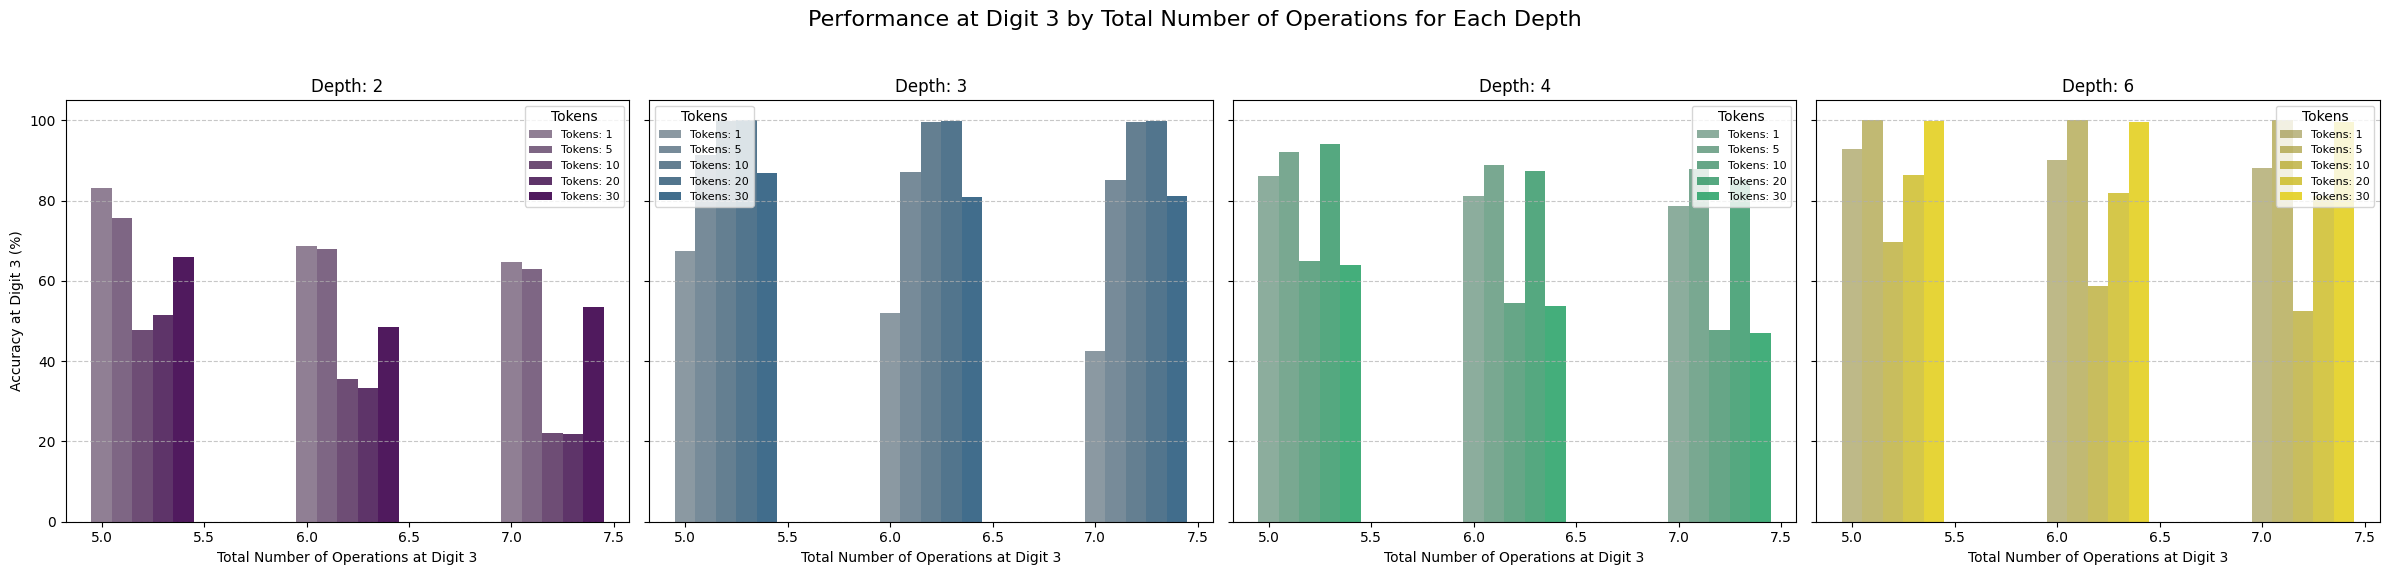

In [22]:

# Calculate operations for all entries
df['Additions_3'], df['Multiplications_3'] = zip(*df.apply(lambda row: count_operations_per_digit_with_carries(int(row['n1']), int(row['n2'])), axis=1))
df['Additions_3'] = df['Additions_3'].apply(lambda x: x.get(3, 0))
df['Multiplications_3'] = df['Multiplications_3'].apply(lambda x: x.get(3, 0))
df['Total_Operations_3'] = df['Additions_3'] + df['Multiplications_3']

# Group data by the total number of operations at the third digit, tokens, and depth, then calculate the mean accuracy at the third digit
df['Position_3_Correct'] = get_digits_at_positions(df['Predictions'])[:, 2] == get_digits_at_positions(df['True Labels'])[:, 2]
grouped_digit_3_df_fresh = df.groupby(['Total_Operations_3', 'tokens', 'depth']).agg({'Position_3_Correct': 'mean'}).reset_index()
grouped_digit_3_df_fresh['Position_3_Accuracy'] = grouped_digit_3_df_fresh['Position_3_Correct'] * 100  # Convert to percentage

# Create a grid of plots, one for each unique depth
fig, axes = plt.subplots(nrows=1, ncols=len(unique_depths_fresh), figsize=(24, 6), sharey=True)

# Plotting
for i, depth in enumerate(unique_depths_fresh):
    ax = axes[i]
    sub_df_depth = grouped_digit_3_df_fresh[grouped_digit_3_df_fresh['depth'] == depth]
    
    for j, tokens in enumerate(unique_tokens_fresh):
        gradient_color = base_colors_fresh[i] * (0.5 + j * 0.5 / len(unique_tokens_fresh))
        sub_df = sub_df_depth[sub_df_depth['tokens'] == tokens]
        ax.bar(sub_df['Total_Operations_3'] + j * 0.1, sub_df['Position_3_Accuracy'], 
               width=0.1, label=f"Tokens: {tokens}", color=gradient_color)
    
    # Labeling and styling for each subplot
    ax.set_title(f'Depth: {depth}')
    ax.set_xlabel('Total Number of Operations at Digit 3')
    if i == 0:
        ax.set_ylabel('Accuracy at Digit 3 (%)')
    ax.legend(title='Tokens', fontsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Overall title and layout
plt.suptitle('Performance at Digit 3 by Total Number of Operations for Each Depth', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()